<div class="alert alert-block alert-info">
<p style="font-size:24px;text-align:center"><b>Simulates a multi-crystal amplifier with BELLA Center's parameters</b>
<br>A 3-crystal configuration, with 4, 3, 3 passes per crystal
</div>

In [1]:
# Laser pulse
num_laser_slices = 41

# Crystal
num_crystal_slices = 3

gain = 1 
radial_n2 = 0
prop_type = 'n0n2_srw'

beamsplitter_transmitted_frac = 0.4

In [2]:
def plot_excited_states(crystal):
    long_excited_states, trans_excited_states = crystal.extract_excited_states()
    z = np.linspace(0,2.5,len(long_excited_states))
    x = np.linspace(-crystal.params.pop_inversion_mesh_extent,
                    crystal.params.pop_inversion_mesh_extent,
                    crystal.params.pop_inversion_n_cells)

    uti_plot.uti_plot2d1d(
        trans_excited_states.flatten(),
        [-crystal.params.pop_inversion_mesh_extent, crystal.params.pop_inversion_mesh_extent, crystal.params.pop_inversion_n_cells],
        [-crystal.params.pop_inversion_mesh_extent, crystal.params.pop_inversion_mesh_extent, crystal.params.pop_inversion_n_cells],
        0,
        0,
        ['Horizontal Position', 'Vertical Position', 'Total Num Excited States'],
        ['m', 'm', 'num'],
        True)
    
    fig = plt.figure()
    ax = fig.gca()
    plt.pcolormesh(x*(1e3), x*(1e3), trans_excited_states, cmap=plt.cm.viridis, shading='auto')
    plt.colorbar()
    ax.set_ylabel(r'Vertical Position [mm]')
    ax.set_xlabel(r'Horizontal Position [mm]')
    ax.set_title('Total Num Excited States')
    plt.show()
    
    plt.figure()
    plt.plot(z,long_excited_states, 'k')
    plt.xlabel('Longitudinal Distance [cm]')
    plt.ylabel('Num Excited States')
    plt.show()

In [3]:
def plot_all(laser_pulse):
    wfr_temp = laser_pulse.slice[0].wfr
    wfr_x = np.linspace(wfr_temp.mesh.xStart,wfr_temp.mesh.xFin,wfr_temp.mesh.nx)
    wfr_y = np.linspace(wfr_temp.mesh.yStart,wfr_temp.mesh.yFin,wfr_temp.mesh.ny)

    e_total_init = laser_pulse.extract_total_2d_elec_fields()
    intens_2d_init = 0.5 *const.c *const.epsilon_0 *(e_total_init.re**2.0 + e_total_init.im**2.0)
    intens0 = intens_2d_init.flatten()

    uti_plot.uti_plot2d1d(
        intens0,
        [wfr_temp.mesh.xStart, wfr_temp.mesh.xFin, wfr_temp.mesh.nx],
        [wfr_temp.mesh.yStart, wfr_temp.mesh.yFin, wfr_temp.mesh.ny],
        0,
        0,
        ['Horizontal Position', 'Vertical Position', 'Intensity'],
        ['m', 'm', 'ph/s/.1%bw/mm^2'],
        True)

    x_min = np.abs(-15.0 - wfr_x*1e3).argmin(axis=0) - 1
    x_max = np.abs(15.0 - wfr_x*1e3).argmin(axis=0) + 1
    
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(4.6*1.5,3.6*1.5))
        ax = fig.gca()
        plt.pcolormesh(wfr_x[x_min:x_max]*(1e3), wfr_y[x_min:x_max]*(1e3), intens_2d_init[x_min:x_max,x_min:x_max], cmap=plt.cm.viridis, shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [mm]')
        ax.set_xlabel(r'Horizontal Position [mm]')
        # plt.xlim(-15,15)
        # plt.ylim(-15,15)
        ax.set_title('Intensity')
        plt.show()
    
    phase_2d_init = laser_pulse.extract_total_2d_phase()
    phase0 = phase_2d_init.flatten()

    uti_plot.uti_plot2d1d(
        phase0,
        [wfr_temp.mesh.xStart, wfr_temp.mesh.xFin, wfr_temp.mesh.nx],
        [wfr_temp.mesh.yStart, wfr_temp.mesh.yFin, wfr_temp.mesh.ny],
        0,
        0,
        ['Horizontal Position', 'Vertical Position', 'Phase'],
        ['m', 'm', ''],
        True)

    print(np.shape(wfr_x[x_min:x_max]),np.shape(wfr_y[x_min:x_max]),np.shape(phase_2d_init[x_min:x_max,x_min:x_max]))
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(4.6*1.5,3.6*1.5))
        ax = fig.gca()
        plt.pcolormesh(wfr_x[x_min:x_max]*(1e3), wfr_y[x_min:x_max]*(1e3), phase_2d_init[x_min:x_max,x_min:x_max], cmap=plt.cm.viridis, shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [mm]')
        ax.set_xlabel(r'Horizontal Position [mm]')
        # plt.xlim(-15,15)
        # plt.ylim(-15,15)
        ax.set_title('Phase')
        plt.show()

#### Imports

In [4]:
import sys, copy
import numpy as np
from pykern.pkcollections import PKDict
import time

from scipy import optimize
from scipy.interpolate import splrep, splev
from scipy import special
from scipy.signal import find_peaks

# The rslaser library may not be installed, so a check is required.
try:
    import rslaser
except:
    # Developers should use 'pip install -e .' from the command line.
    # Users can install directly from GitHub --
    !{sys.executable} -m pip install git+https://github.com/radiasoft/rslaser.git
    import rslaser

from rsmath import lct as rslct
from rslaser.pulse import pulse
from rslaser.optics import crystal
from rslaser.optics import drift
from rslaser.optics import lens
import rslaser.utils.srwl_uti_data as srwutil
import uti_plot

import srwlib
import rslaser.utils.unit_conversion as units

import scipy.constants as const
from scipy import interpolate
from scipy.interpolate import RectBivariateSpline
from scipy import special

# 2D plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

# reset the notebook style
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['pcolor.shading'] ='auto'
%matplotlib inline

### Laser Pulse

In [5]:
w0 = 3.056e-3 
l_scale = np.sqrt(np.pi)*w0

params = PKDict(
    num_sig_long = 6,
    photon_e_ev = 1.5498, # Photon energy [eV], calculated from 800nm wavelength
    nslice      = num_laser_slices,
    pulseE      = 0.002,
    tau_fwhm    = 300.0e-12 * np.sqrt(2.),
    tau_0       = 35.0e-15 * np.sqrt(2.),
    sigx_waist  = w0/np.sqrt(2.0),
    sigy_waist  = w0/np.sqrt(2.0),
    num_sig_trans=10,
    nx_slice=512, #256, #128, #
    phase_flatten_cutoff=0.7,
)

***
## Initial Intensity and Phase

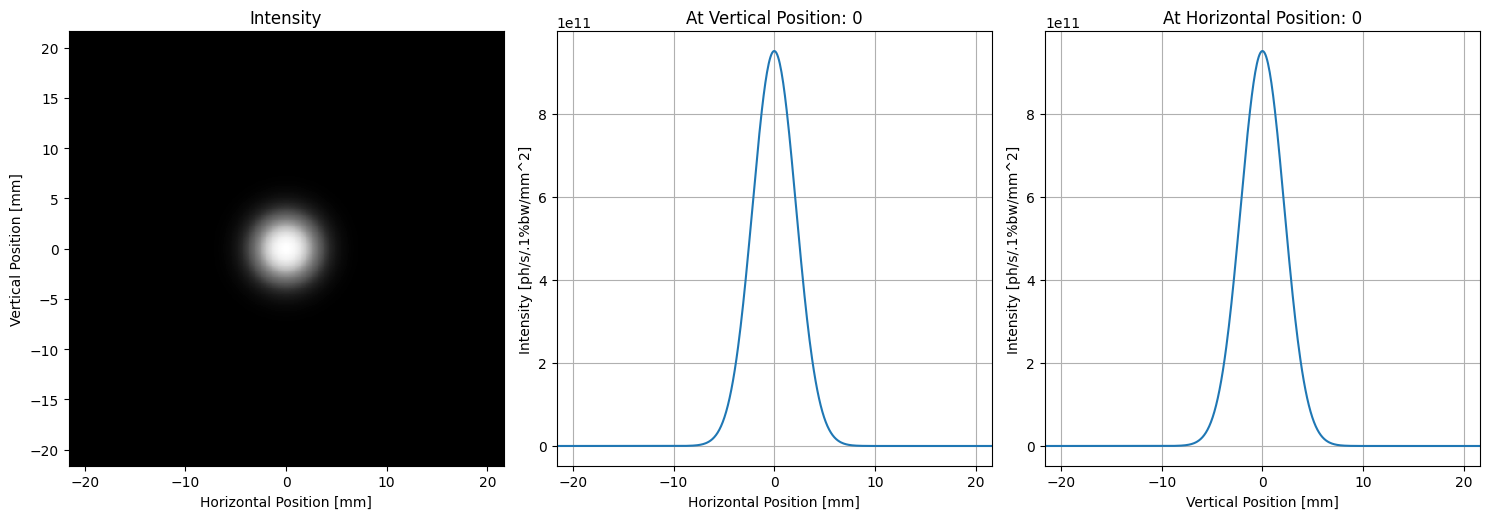

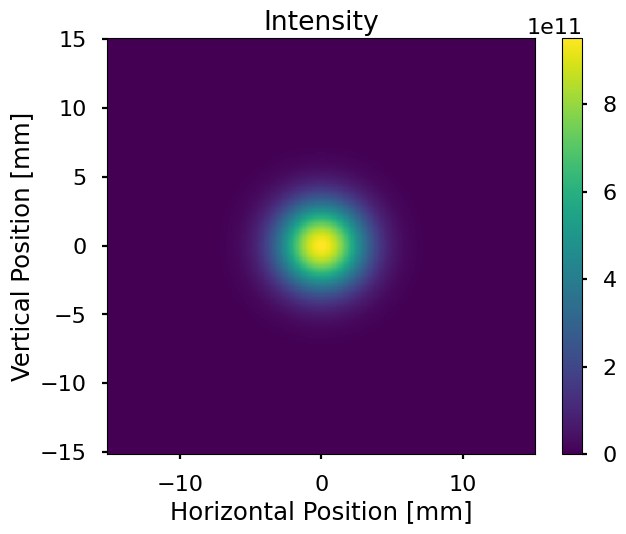

(357,) (357,) (357, 357)


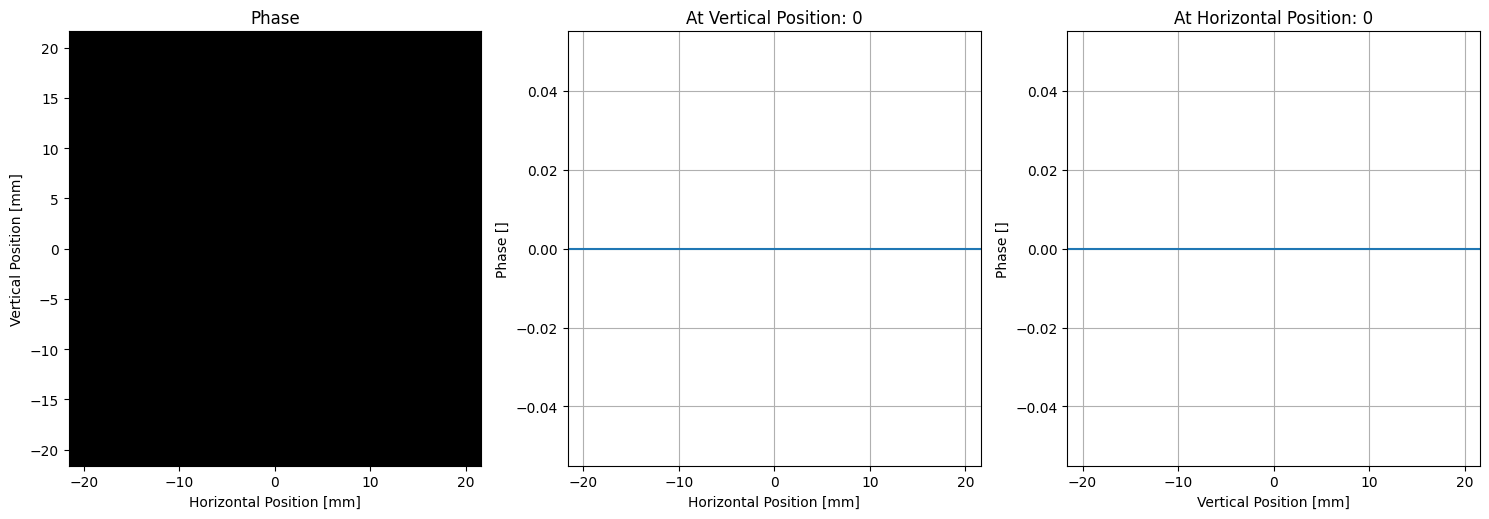

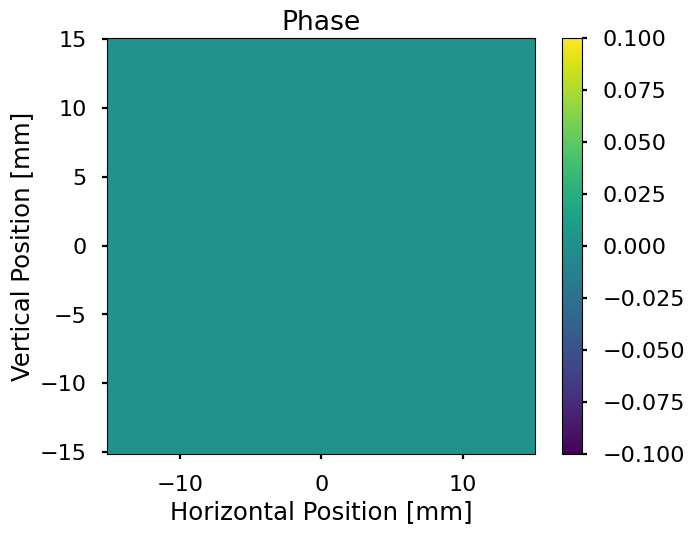

In [10]:
thisPulse_initial = pulse.LaserPulse(params)
thisPulse_initial.zero_phase()
plot_all(thisPulse_initial)

In [11]:
print(thisPulse_initial.calc_total_energy())

0.0020056164748069333


In [12]:
rayleigh_length = np.pi * (thisPulse_initial.sigx_waist)**2.0 / (thisPulse_initial._lambda0)
print('Rayleigh Length:', round(rayleigh_length,3), ' m')
print('RMS bunch length:', round(thisPulse_initial.sig_s,3), ' m')

Rayleigh Length: 18.337  m
RMS bunch length: 0.054  m


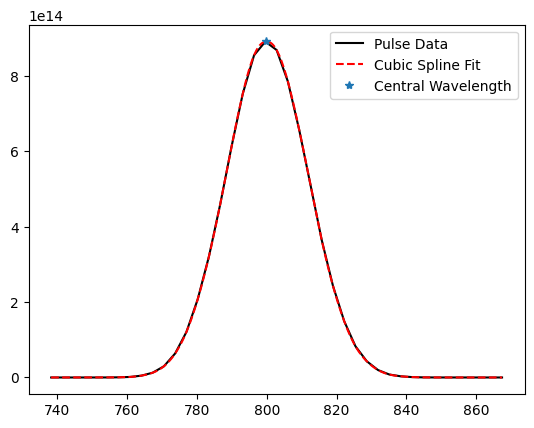

In [13]:
central_wavelength, mean_wavelength = thisPulse_initial.central_and_mean_wavelength(plot=True)